In [154]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import quandl as qd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from pandas_datareader import data

%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

# Function for cleaning CBOE VIX data
def clean_cboe(df):
    df.columns = ['Date','Open','High','Low','Close']
    df = df[1:]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    return df[['Open','High','Low','Close']]

# Function for cleaning Local data
def clean_local(df):
    df.columns = ['Date','Open','High','Low','Close', 'Adj Close', 'Volume']
    df = df[1:]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    return df[['Open','High','Low','Close', 'Adj Close']]

# Function for cleaning Quandl data
def clean_qd(df):
    df.columns = ['Date', 'Open', 'High', 'Low', 'Settle', 'Volume', 'Prev. Day Open Interest']
    df = df[1:]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    return df[['Open', 'High', 'Low', 'Settle', 'Volume', 'Prev. Day Open Interest']]

# Changing directory to pull local .csv files for SPX 
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\SPX Option Backtester\\spx_options_backtesting\\SPX Data')
spx = pd.read_csv('SPX.csv')
spx = clean_local(spx)
spx = spx[['Open','Close']]
spx.columns = ['SPX_{0}'.format(header) for header in spx.columns.tolist()]

# Creating HV column to compare against VIX
spx['Daily Log-Return'] = np.log(spx['SPX_Close']) - np.log(spx['SPX_Close'].shift(1))
spx['Squared Daily Return'] = np.square(spx['Daily Log-Return'])
spx['Rolling Variance'] = (spx['Squared Daily Return'].rolling(window=21).mean()*365)
spx['Return Stdev'] = np.sqrt(spx['Rolling Variance'])
spx['HV'] = spx['Return Stdev']*100
spx = spx[['SPX_Open','SPX_Close','HV']]

vxx = pd.read_csv('VXX.csv')
vxx = clean_local(vxx)
vxx = vxx[['Open','Adj Close']]
vxx.columns = ['Open', 'Close']
vxx.columns = ['VXX_{0}'.format(header) for header in vxx.columns.tolist()]

# Importing futures data from Quandl
v1 = qd.get("SCF/CBOE_VX1_EN", authtoken="dzmzEExntfap7SNx5p6t")[['Open','Settle']]
#pd.read_csv('https://www.quandl.com/api/v3/datasets/SCF/CBOE_VX1_EN.csv?api_key=dzmzEExntfap7SNx5p6t')
#v1 = clean_qd(v1)
v1 = v1[['Open','Settle']]
v1.columns = ['V1_{0}'.format(header) for header in v1.columns.tolist()]

v2 = qd.get("SCF/CBOE_VX2_EN", authtoken="dzmzEExntfap7SNx5p6t")[['Open','Settle']]
#pd.read_csv('https://www.quandl.com/api/v3/datasets/SCF/CBOE_VX2_EN.csv?api_key=dzmzEExntfap7SNx5p6t')
#v2 = clean_qd(v2)
#v2 = v2[['Open','Settle']]
v2.columns = ['V2_{0}'.format(header) for header in v2.columns.tolist()]

# Importing VIX Spot Data from CBOE
# First read raw files directly 
vix_present = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv').dropna()
# vix_old = pd.read_excel('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixarchive.xls').dropna()
vxo_old = pd.read_excel('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vxoarchive.xls').dropna()

# Applying clean_cboe to vix data
vix_present = clean_cboe(vix_present)
# vix_old = clean_cboe(vix_old)
vxo_old = clean_cboe(vxo_old)

# Currently the vix_old dataframe doesn't have the Open prices so VXO will be used to proxy VIX prior
# to 2003
vix = pd.concat([vxo_old,vix_present],axis = 0)[['Open','Close']]
vix.columns = ['VIX_{0}'.format(header) for header in vix.columns.tolist()]
del vxo_old, vix_present
vix['VIX_Close'][3733] = 32.5

# Fixing VIX values so that they are floats
vix['VIX_Close'] = vix['VIX_Close'].astype('float')
vix['VIX_Open'] = vix['VIX_Open'].astype('float')

# Changing directory back to IPython Notebook
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\SPX Option Backtester\\spx_options_backtesting\\IPython Notebook')

# Collapse into one dataframe
df = pd.concat([vxx,spx,vix,v1,v2], axis = 1).dropna()

# Creating Front and Back Month Weights for Contango Ratio
df['Prev_Wed'] = df.index
df['Cur_Wed'] = df.index
df['Next_Wed'] = df.index
df['Front Weight'] = 1.0
df['Back Weight'] = 0.0

for index, row in df.iterrows():
    # Initializing Date Values
    curr_month = index.month
    curr_year = index.year
    curr_day = index.day
    
    # Finding Previous Third Wednesday
    curr_eighth = dt.date(curr_year,curr_month,7)
    curr_second = dt.date(curr_year,curr_month,3).weekday()
    curr_third_fri = curr_eighth - dt.timedelta(curr_second) + dt.timedelta(14)
    last_third_wed = curr_third_fri - dt.timedelta(30)
    df['Prev_Wed'][index] = last_third_wed
    
    # Finding Next Third Wed
    if curr_month == 12:
        next_month = 2
        next_year = curr_year + 1
    elif curr_month == 11:
        next_month = 1
        next_year = curr_year + 1
    else:
        next_month = curr_month + 2
        next_year = curr_year
    next_eigth_day = dt.date(next_year,next_month,7)
    next_second_day = dt.date(next_year,next_month,3).weekday()
    next_third_fri = next_eigth_day - dt.timedelta(next_second_day) + dt.timedelta(14)
    next_third_wed = next_third_fri - dt.timedelta(30)
    df['Next_Wed'][index] = next_third_wed
    
    # Finding Current Third Wed
    if curr_month == 12:
        next_month = 1
        next_year = curr_year + 1
    else:
        next_month = curr_month + 1
        next_year = curr_year
    next_eigth_day = dt.date(next_year,next_month,7)
    next_second_day = dt.date(next_year,next_month,3).weekday()
    next_third_fri = next_eigth_day - dt.timedelta(next_second_day) + dt.timedelta(14)
    curr_third_wed = next_third_fri - dt.timedelta(30)
    df['Cur_Wed'][index] = curr_third_wed
    
    # Finding Term: When current date is after expiry, should be 100% of spot/f1
    if index.date() < curr_third_wed:
        dte = curr_third_wed - index.date()
        term = curr_third_wed - last_third_wed
    else:
        dte = next_third_wed - index.date()
        term = next_third_wed - curr_third_wed
    front_weight = float(dte.days)/term.days
    df['Front Weight'][index] = front_weight
    df['Back Weight'][index] = 1 - front_weight
    
del vxx, spx, v1, v2, vix

df = df[['VXX_Open', 'VXX_Close', 'SPX_Open', 'SPX_Close',
         'HV', 'VIX_Open', 'VIX_Close', 'V1_Open', 'V1_Settle',
         'V2_Open', 'V2_Settle', 'Front Weight', 'Back Weight']]

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Fang\Anaconda3\lib\site-packag

In [235]:
test = df[['VXX_Close','SPX_Close','HV','VIX_Close','V1_Settle','V2_Settle','Front Weight','Back Weight']]
test['F_Contango'] = test['VIX_Close']/test['V1_Settle']
test['B_Contango'] = test['V1_Settle']/test['V2_Settle']
test['Contango'] = test['F_Contango']*test['Front Weight'] + test['B_Contango']*test['Back Weight']
test = test[['VXX_Close','SPX_Close','HV','VIX_Close','Contango']]

def percent_updays(dataframe, roll_days, cont_thresh, display = True):
    plot_df['VXX_Return'] = round((dataframe['VXX_Close'].shift(-roll_days)/dataframe['VXX_Close'] - 1)*100,2)
    breach_df = plot_df[plot_df['Contango'] >= cont_thresh]
    down_days = len(breach_df[breach_df['VXX_Return'] < 0])
    up_days = len(breach_df[breach_df['VXX_Return'] > 0])
    up_down_ratio = round(float(up_days)/(len(breach_df)),2)
    
    if display:
        plot_df['VXX_Return'].hist(bins = 30, figsize = (20,10))
        print("Number of Negative Returns: " + str(down_days))
        print("Number of Positive Returns: " + str(up_days))
        print("Ratio of Positive to Negative Returns: " + str(up_down_ratio))
        print(pd.DataFrame.sort_values(plot_df,by = 'VXX_Return', ascending = False).head(10))
    
    return up_down_ratio

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [265]:
roll = 11
thresh = 1.17
ratios = []
attrib = []
for i in range(1,20):
    for j in np.arange(1,1.20,0.01):
        ratio = percent_updays(test, i, j, display = False)
        ratios = ratios + [ratio]
        ind = "Roll: " + str(i) + " " + "Cont: " + str(j)
        attrib = attrib + [ind]
        
check = pd.DataFrame({"Index": attrib,
                    "Ratios": ratios})
check.ix[check['Ratios'].argmax(),:]

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


Index     Roll: 11 Cont: 1.17
Ratios                    0.9
Name: 217, dtype: object

Number of Negative Returns: 1
Number of Positive Returns: 9
Ratio of Positive to Negative Returns: 0.9
               VXX_Close    SPX_Close         HV  VIX_Close  Contango  \
Date                                                                    
2011-08-03   6164.479980  1260.339966  20.175997      23.38  1.034796   
2011-07-26   5632.000000  1331.939941  17.595028      20.23  1.012322   
2011-08-04   7395.839844  1200.069946  28.709607      31.66  1.103268   
2011-08-01   5736.959961  1286.939941  17.947535      23.66  1.083792   
2011-07-27   5964.799805  1304.890015  19.189236      22.98  1.053983   
2011-08-05   7759.359863  1199.380005  28.381355      32.00  1.106242   
2011-07-28   6103.040039  1300.670044  18.474311      23.74  1.075352   
2010-04-21  19036.160156  1205.939941  11.904132      16.32  1.032911   
2011-08-02   6136.319824  1254.050049  20.075629      24.79  1.066149   
2011-07-29   5992.959961  1292.280029  18.350836      25.25  1.133463   

            VXX_Retu

0.9

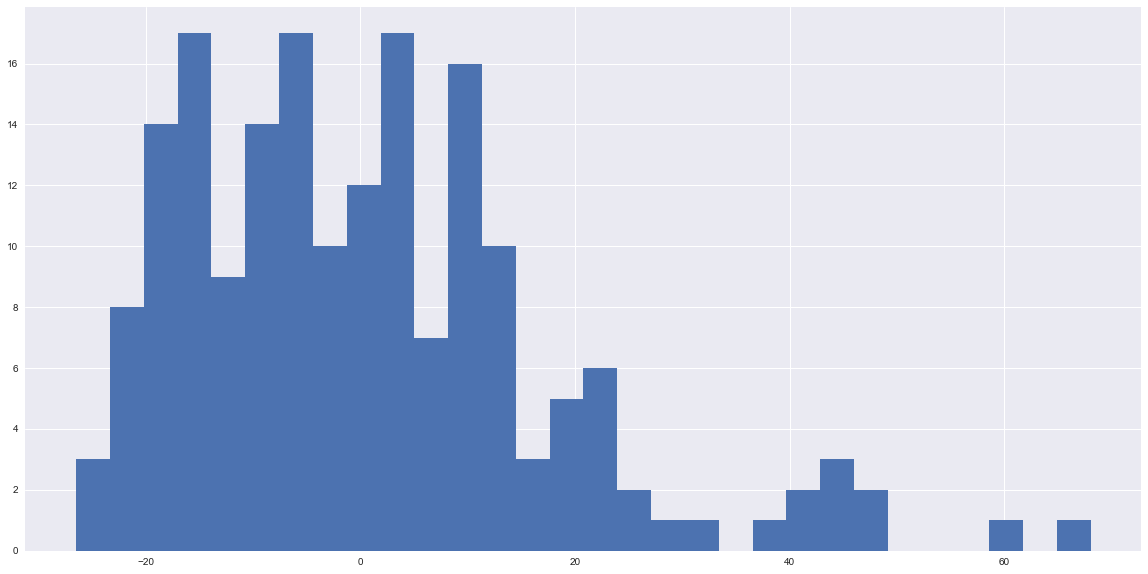

In [264]:
percent_updays(test, roll, thresh, display = True)

In [266]:
check

,Index,Ratios
0,Roll: 1 Cont: 1.0,0.45
1,Roll: 1 Cont: 1.01,0.45
2,Roll: 1 Cont: 1.02,0.48
3,Roll: 1 Cont: 1.03,0.45
4,Roll: 1 Cont: 1.04,0.44
5,Roll: 1 Cont: 1.05,0.43
6,Roll: 1 Cont: 1.06,0.44
7,Roll: 1 Cont: 1.07,0.45
8,Roll: 1 Cont: 1.08,0.47
9,Roll: 1 Cont: 1.09,0.43
